In [2]:
import pynamod
import torch
import h5py
from pynamod.geometry.trajectories import H5_Trajectory

/home/v_vasilev/.conda/envs/pynamod_env/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/v_vasilev/.conda/envs/pynamod_env/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


/home/v_vasilev/.conda/envs/pynamod_env/lib/python3.11/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(
/home/v_vasilev/.conda/envs/pynamod_env/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


In [3]:
import warnings
warnings.filterwarnings('ignore')

### Full Atomic Structure Analysis

In [13]:
nucl = pynamod.CG_Structure(pdb_id='3lz0')
#Also can be initialized with pdb filename or mda Universe
nucl.analyze_dna(leading_strands=['I'])
nucl.analyze_protein(n_cg_beads=80)

Sending GET request to https://files.rcsb.org/download/3lz0.pdb to fetch 3lz0's pdb file as a string.


NGLWidget()

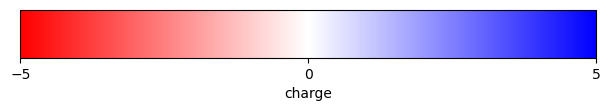

In [14]:
nucl.view_structure()

In [15]:
#Or load existing file
nucl = pynamod.CG_Structure()
file = h5py.File('cg_3lz0.h5','r')
nucl.load_from_h5(file)

### Linear DNA generation

In [16]:
seq = 'atcg'*4
dna_gen = pynamod.CG_Structure()
dna_gen.build_dna(seq)

NGLWidget()

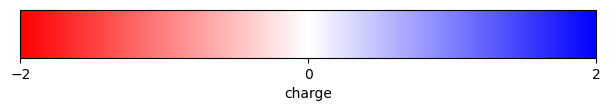

In [17]:
dna_gen.view_structure()


### Structures merge

In [19]:
nucl.append_structures([dna_gen,nucl]*3)

NGLWidget()

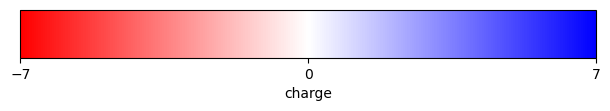

In [20]:
nucl.view_structure()

### Monte Karlo Simulations

System preparation

In [21]:
en = pynamod.Energy(K_bend=1)
en.set_energy_matrices(nucl,ignore_neighbors=20)

In [23]:
#Usually only linker dna should be movable
movable = torch.ones(nucl.dna.ref_frames.shape[0],dtype=bool)
movable[0] = False
start = 0
nucl_dna_ln = 145
for i in nucl.proteins[:-1]:
    stop = start + nucl_dna_ln
    movable[start:stop] = False
    start = stop + len(dna_gen.dna.pairs_list)
movable[-nucl_dna_ln:] = False

In [27]:
traj = H5_Trajectory('example_traj.h5',len(nucl.dna.pairs_list),mode='w')

Запуск моделирования

In [28]:
intg = pynamod.Iterator(nucl,en,traj,sigma_rot=0.1,sigma_transl=0.1)

In [31]:
intg.run(movable,target_accepted_steps=1000,max_steps=10000,device='cuda',KT_factor=0.5,save_every=1,transfer_to_memory_every=100)

Steps:   0%|          | 0/10000 [00:00<?, ?it/s]

Acceptance rate:   0%|          

Start time: 06/06/25 10:51:59
target accepted steps reached
Finish time: 06/06/25 10:52:29
it/s: 57.92
accepted steps: 1000
total steps: 1414
acceptance rate: 70.72135785007072


Visualize trajectory

In [34]:
nucl.dna.geom_params.trajectory = traj

In [45]:
u = nucl.get_cg_mda_traj()

In [46]:
import nglview as nv
v = nv.show_mdanalysis(u)
v.clear()
v.add_representation('spacefill',radius =10)
v

NGLWidget(max_frame=2417)

In [43]:
traj.total_energies

array([32573.30525562, 32573.03198707, 32575.49656463, ...,
       32567.97441602, 32567.80707908, 32568.25355768])

In [44]:
# To continue simulations start_from_traj should be used
intg.run(movable,target_accepted_steps=1000,max_steps=10000,device='cuda',KT_factor=0.5,save_every=1,transfer_to_memory_every=100,start_from_traj=True)

Steps:   0%|          | 0/10000 [00:00<?, ?it/s]

Acceptance rate:   0%|          

Start time: 06/06/25 10:55:26
target accepted steps reached
Finish time: 06/06/25 10:55:55
it/s: 48.97
accepted steps: 1000
total steps: 1373
acceptance rate: 72.83321194464676
